

I had no prior experience with LIDAR, so It this project took more time than expected. Here is how I approached this problem.

I browsed various LIDAR datasets from various sources including Opentopography (https://opentopography.org/), OpenData DC (https://opendata.dc.gov/) etc. I started with the Golden Gate(SF, Calafornia) Dataset and begian exploring it using QGIS. The data set is not classified and massive (9 million points)

Quick rundown of what I will do
1. Convert ground lidar points to a binary road mask
2. Filter the mask to get road mask. We will go for major roads for now
3. Use Hough Transform to detect lines. The roads will be detected here
4. Cluster the lines which belong to same road, filter them
5. Get a box which covers the lines, The length and width of this box is the length and width of the associated road.

This didnt work as I expected however. Scroll down to see why.

I found an aws tutorial [repository](https://github.com/aws-samples/aws-open-data-satellite-lidar-tutorial) where they trained a VGG-16 Unet model to segment roads and provided a copy of trained network as well. It can segment roads and get road length but not width. Maybe it can be used to improve this method.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd '/content/drive/My Drive/lidar'

/content/drive/My Drive/lidar


In [3]:
!pip install matplotlib
!pip install laspy
!pip install opencv-python
# !pip install geopandas
# !pip install pyntcloud
# !pip install gdal
# !pip install cuML

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for laspy: filename=laspy-2.4.1-py3-none-any.whl size=68045 sha256=ed87ad093a23491a8c8d9685d369d7dea66932d66d4aa8e057011157167bcea9
  Stored in directory: /root/.cache/pip/wheels/04/a4/0c/c8e8ba29abc06fafe864c7c4402748ceb617a7c057e8cc8579
Successfully built laspy


In [4]:
import os
import matplotlib.pyplot as plt
import laspy
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import pyntcloud

In [5]:
data_folder = "data"

Loading dataset. Can't load from .laz files, so I just extracted it via laszip

In [6]:
# Open the .las file
with laspy.open('data/SFGG.las') as fh:
    print('Points from Header:', fh.header.point_count)
    las = fh.read()
    print(las)
    print('Points from data:', len(las.points))

Points from Header: 9408030
<LasData(1.2, point fmt: <PointFormat(1, 0 bytes of extra dims)>, 9408030 points, 1 vlrs)>
Points from data: 9408030


Here is what it looks like (This is a flipped image), Viewer - plas.io
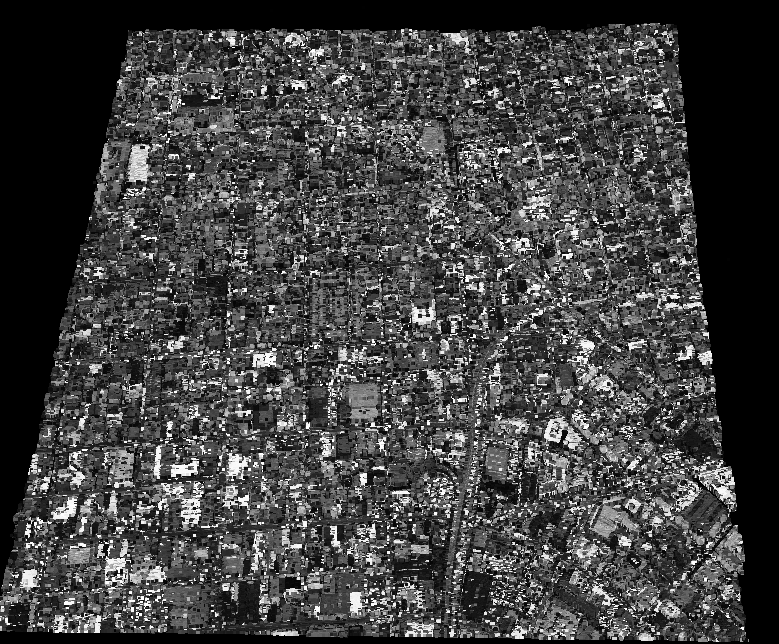

We only need the ground points

In [7]:
ground_points = las.points[las.classification == 2]

In [8]:
min_x = np.min(ground_points["X"])
max_x = np.max(ground_points["X"])
min_y = np.min(ground_points["Y"])
max_y = np.max(ground_points["Y"])

print(min_x,max_x,min_y,max_y)

6500001 8000000 27500000 29000000


Converting to an image of managable but usable dimensions. The idea is to not get too high resolution or Individual lidar points will start showing up and that wont help with image processing. Also, processing that will take forever. Too low resolution and we will miss on details.

I tried with multiple values and setlled down with 1500

In [9]:
import math

scale = 1500  # Scale of 1:1500

width = int(math.ceil((max_x - min_x) / scale))
height = int(math.ceil((max_y - min_y) / scale))

scale is the factor by which the image will be down sampled. Higher the scale, lower the resolution.
Orignally, the lidar cloud covers a 1500 x 1500 m^2 area

In [10]:
image = np.zeros((height + 1, width+ 1), dtype=np.uint8)

In [11]:
image.shape

(1001, 1001)

In [12]:
import cv2

for point in ground_points:
    x = int((point["X"] - min_x) / scale)
    y = height - int((point["Y"] - min_y) / scale)
    image[y, x] = 255  # Set the pixel value to 255 (white)


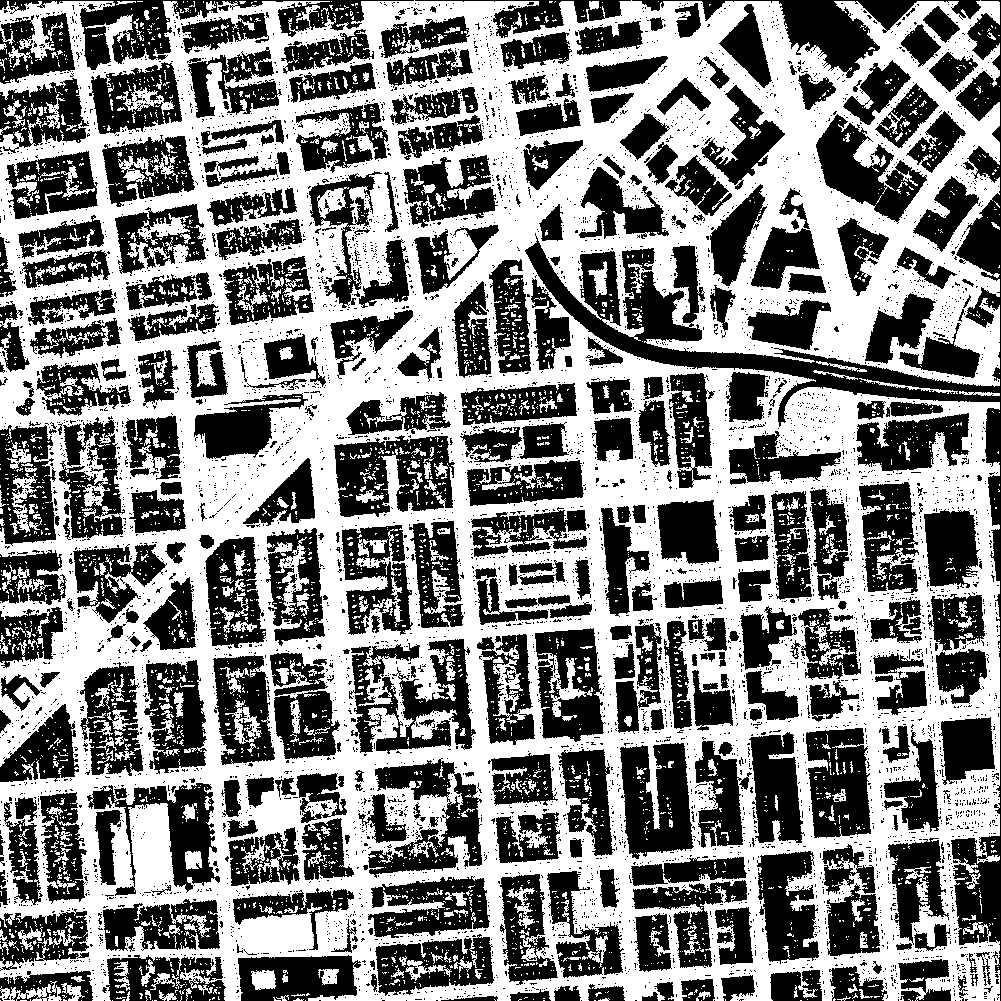

In [13]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

The ground points have a lot of other features beside roads, We need to filter them

In [14]:
cv2.imwrite("ground_image_1500.tiff", image)

True

This takes considerable time. So saving the image. You can find some more in the shared drive link. For using saved images, make sure you binarize them before using

Below are some attempts at removing the ground points which are not part of roads. 

I tried mixing and matching blurring, morphological opening and closing, bilateral filter and connected components. You can see how they affect the image

In [15]:
blur = cv2.medianBlur(image, 3)

In [16]:
M = np.ones((3,3),np.uint8)
opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, M, (-1,-1))

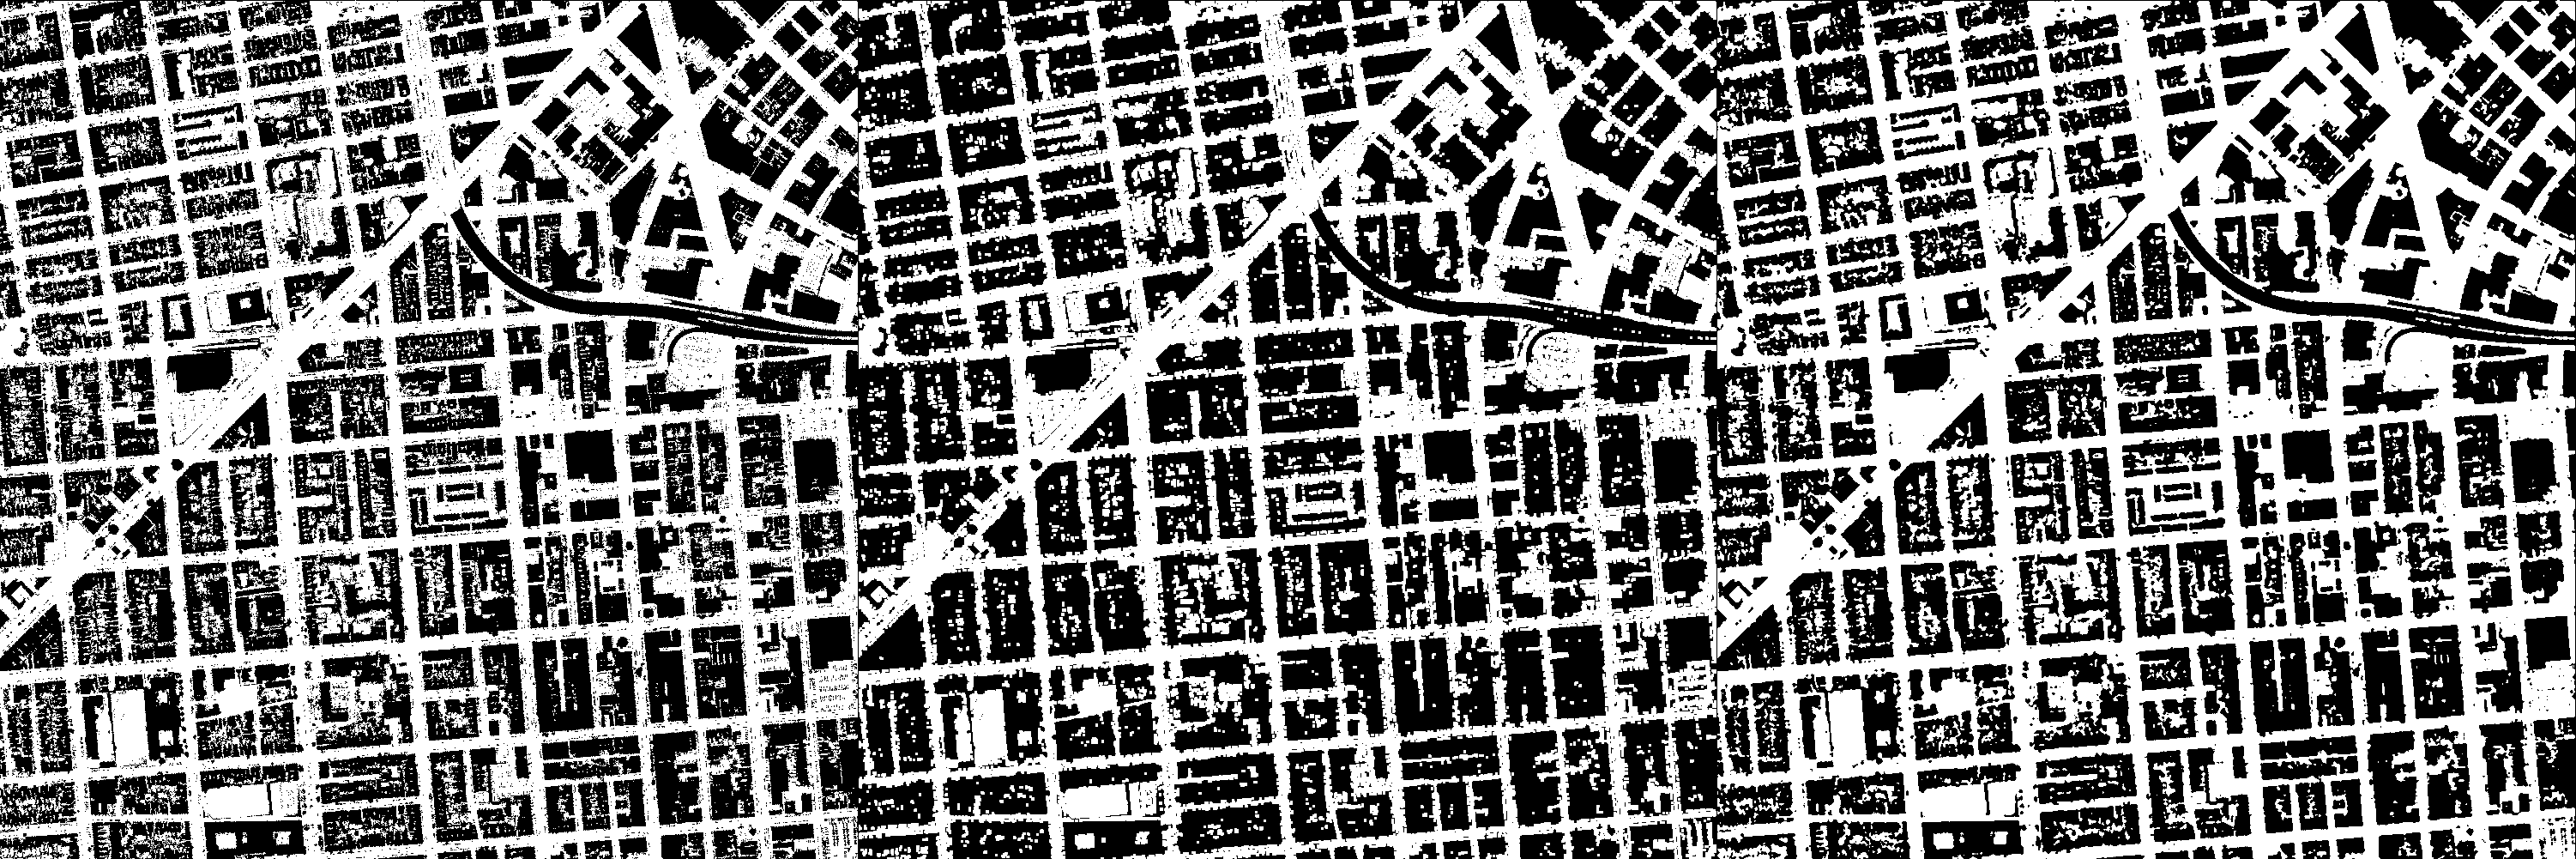

In [17]:
temp = cv2.hconcat([image,opened_image,blur])
cv2_imshow(temp)

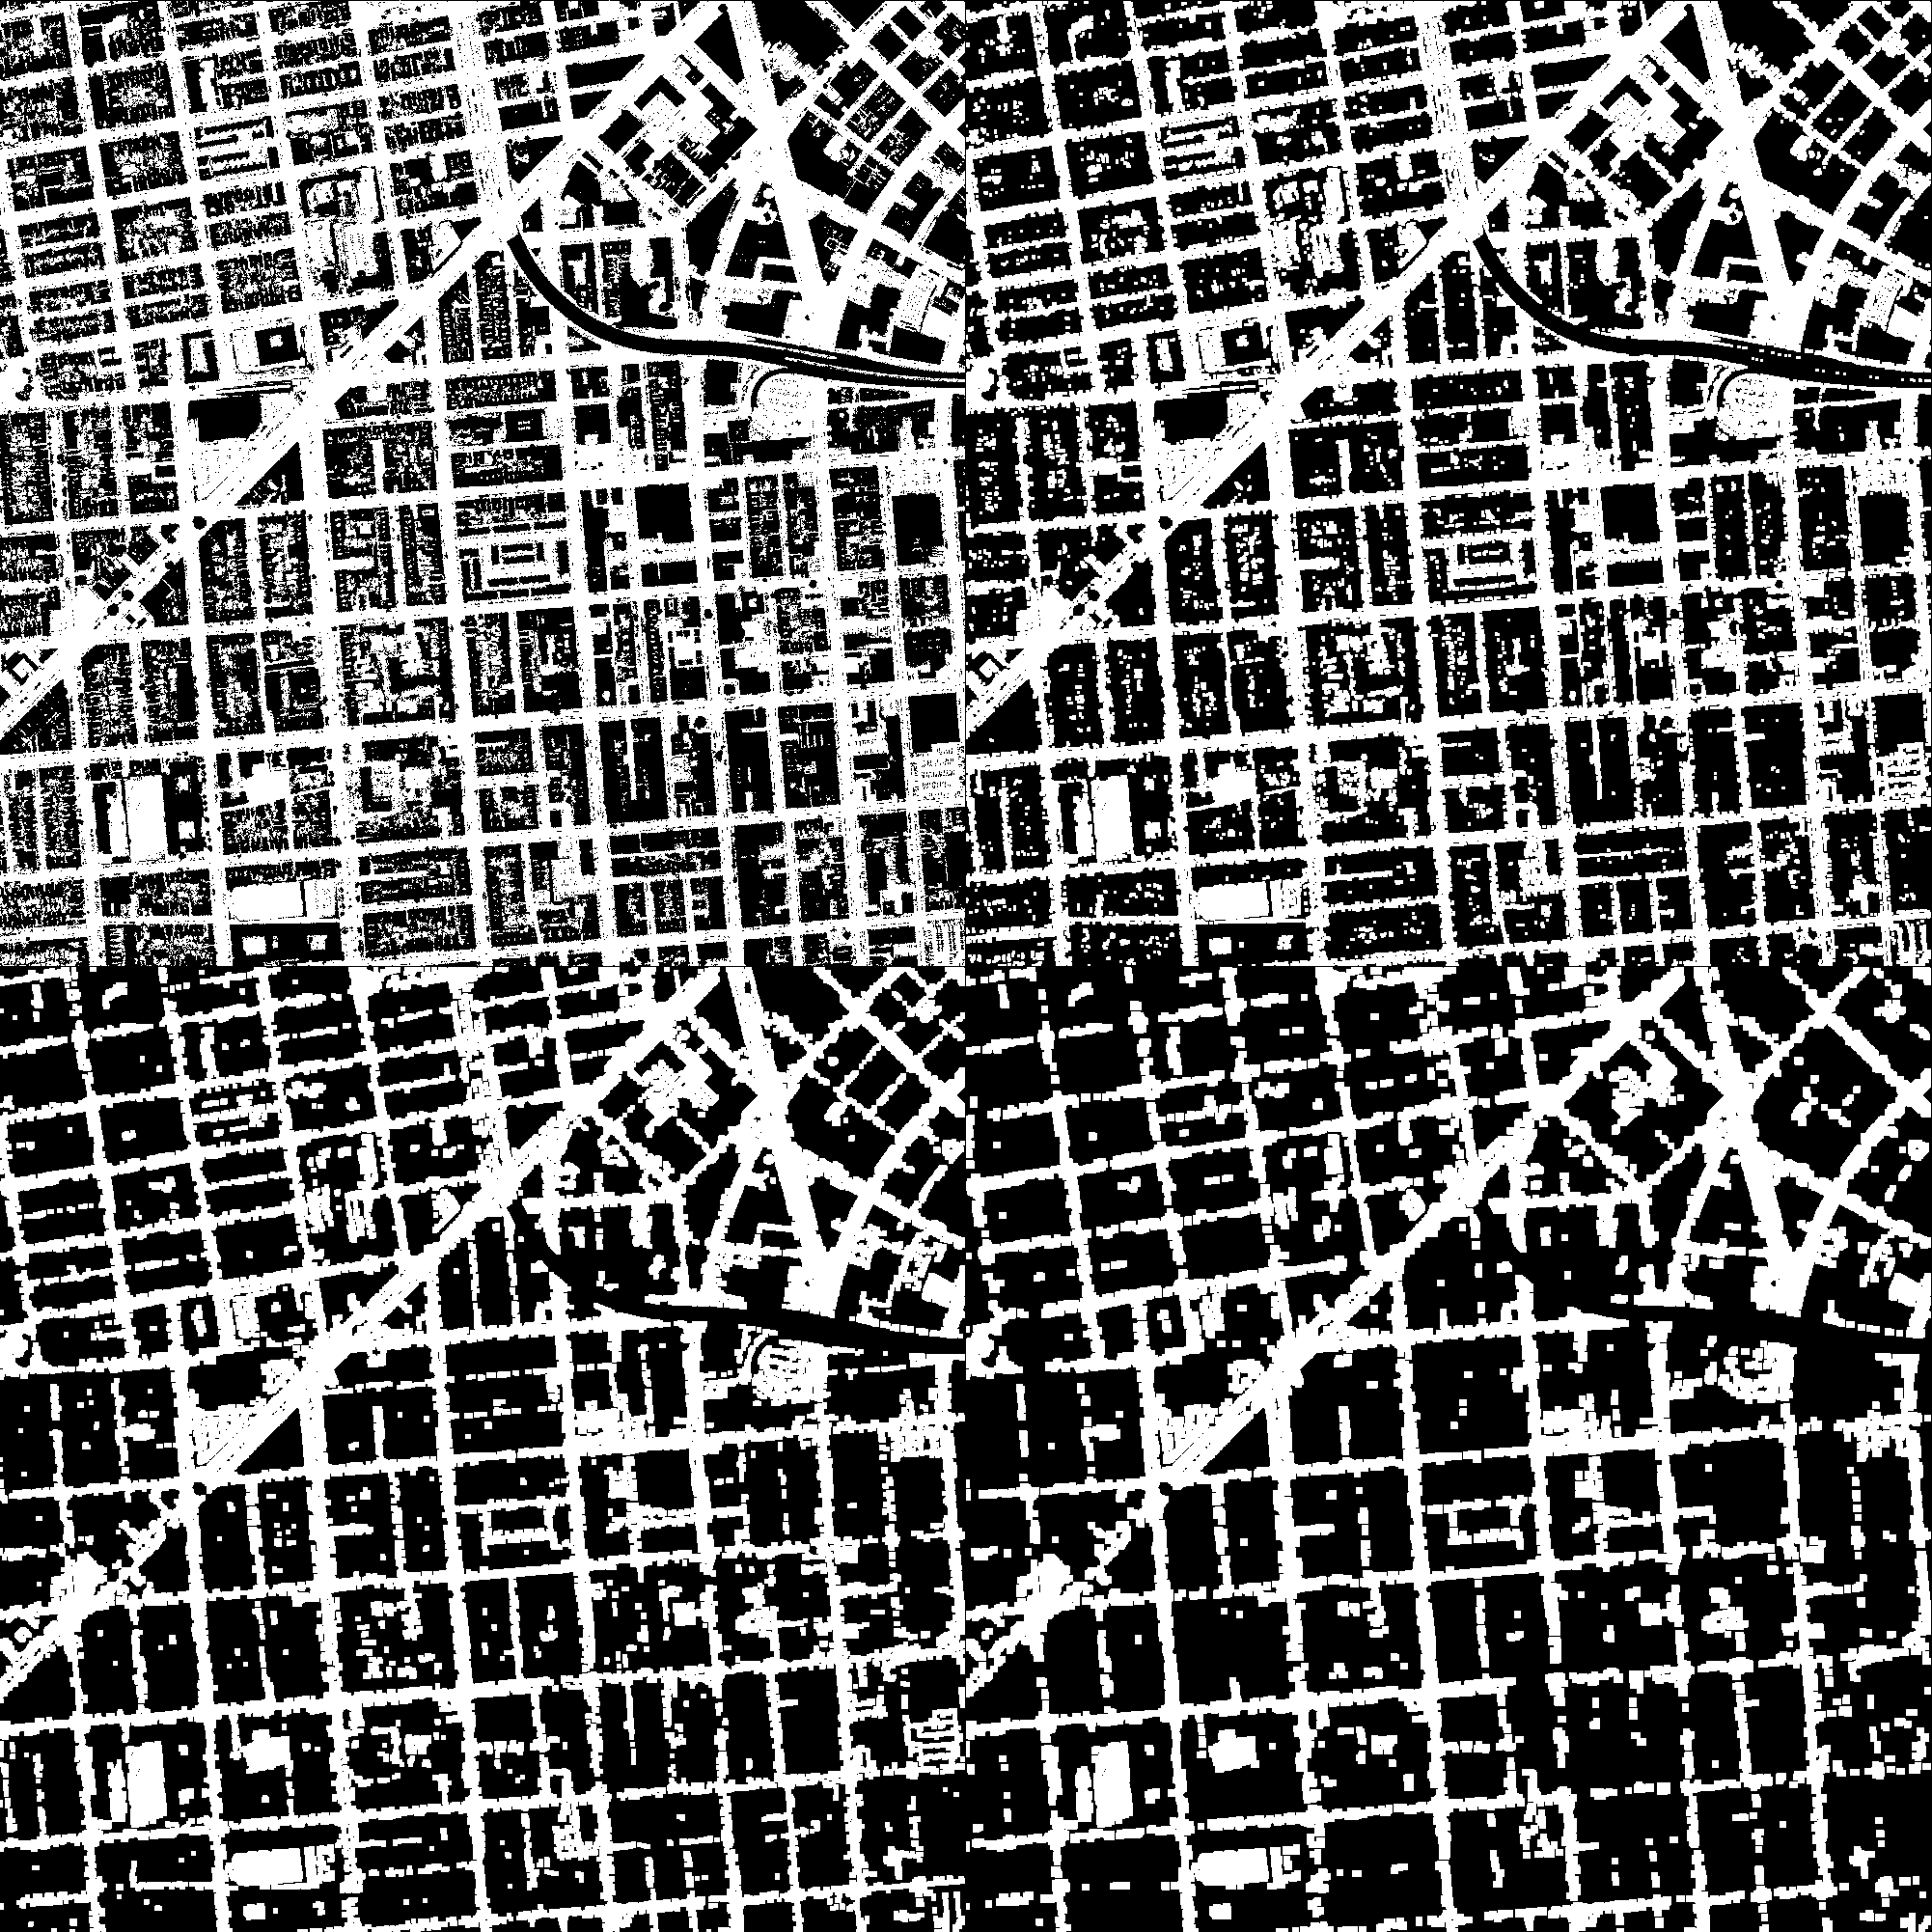

In [18]:
opened_image_2 = cv2.morphologyEx(image, cv2.MORPH_OPEN, M, (-1,-1),iterations = 2)
opened_image_3 = cv2.morphologyEx(image, cv2.MORPH_OPEN, M, (-1,-1),iterations = 3)
temp_2 = cv2.vconcat([cv2.hconcat([image,opened_image]),cv2.hconcat([opened_image_2,opened_image_3])])
cv2_imshow(temp_2)

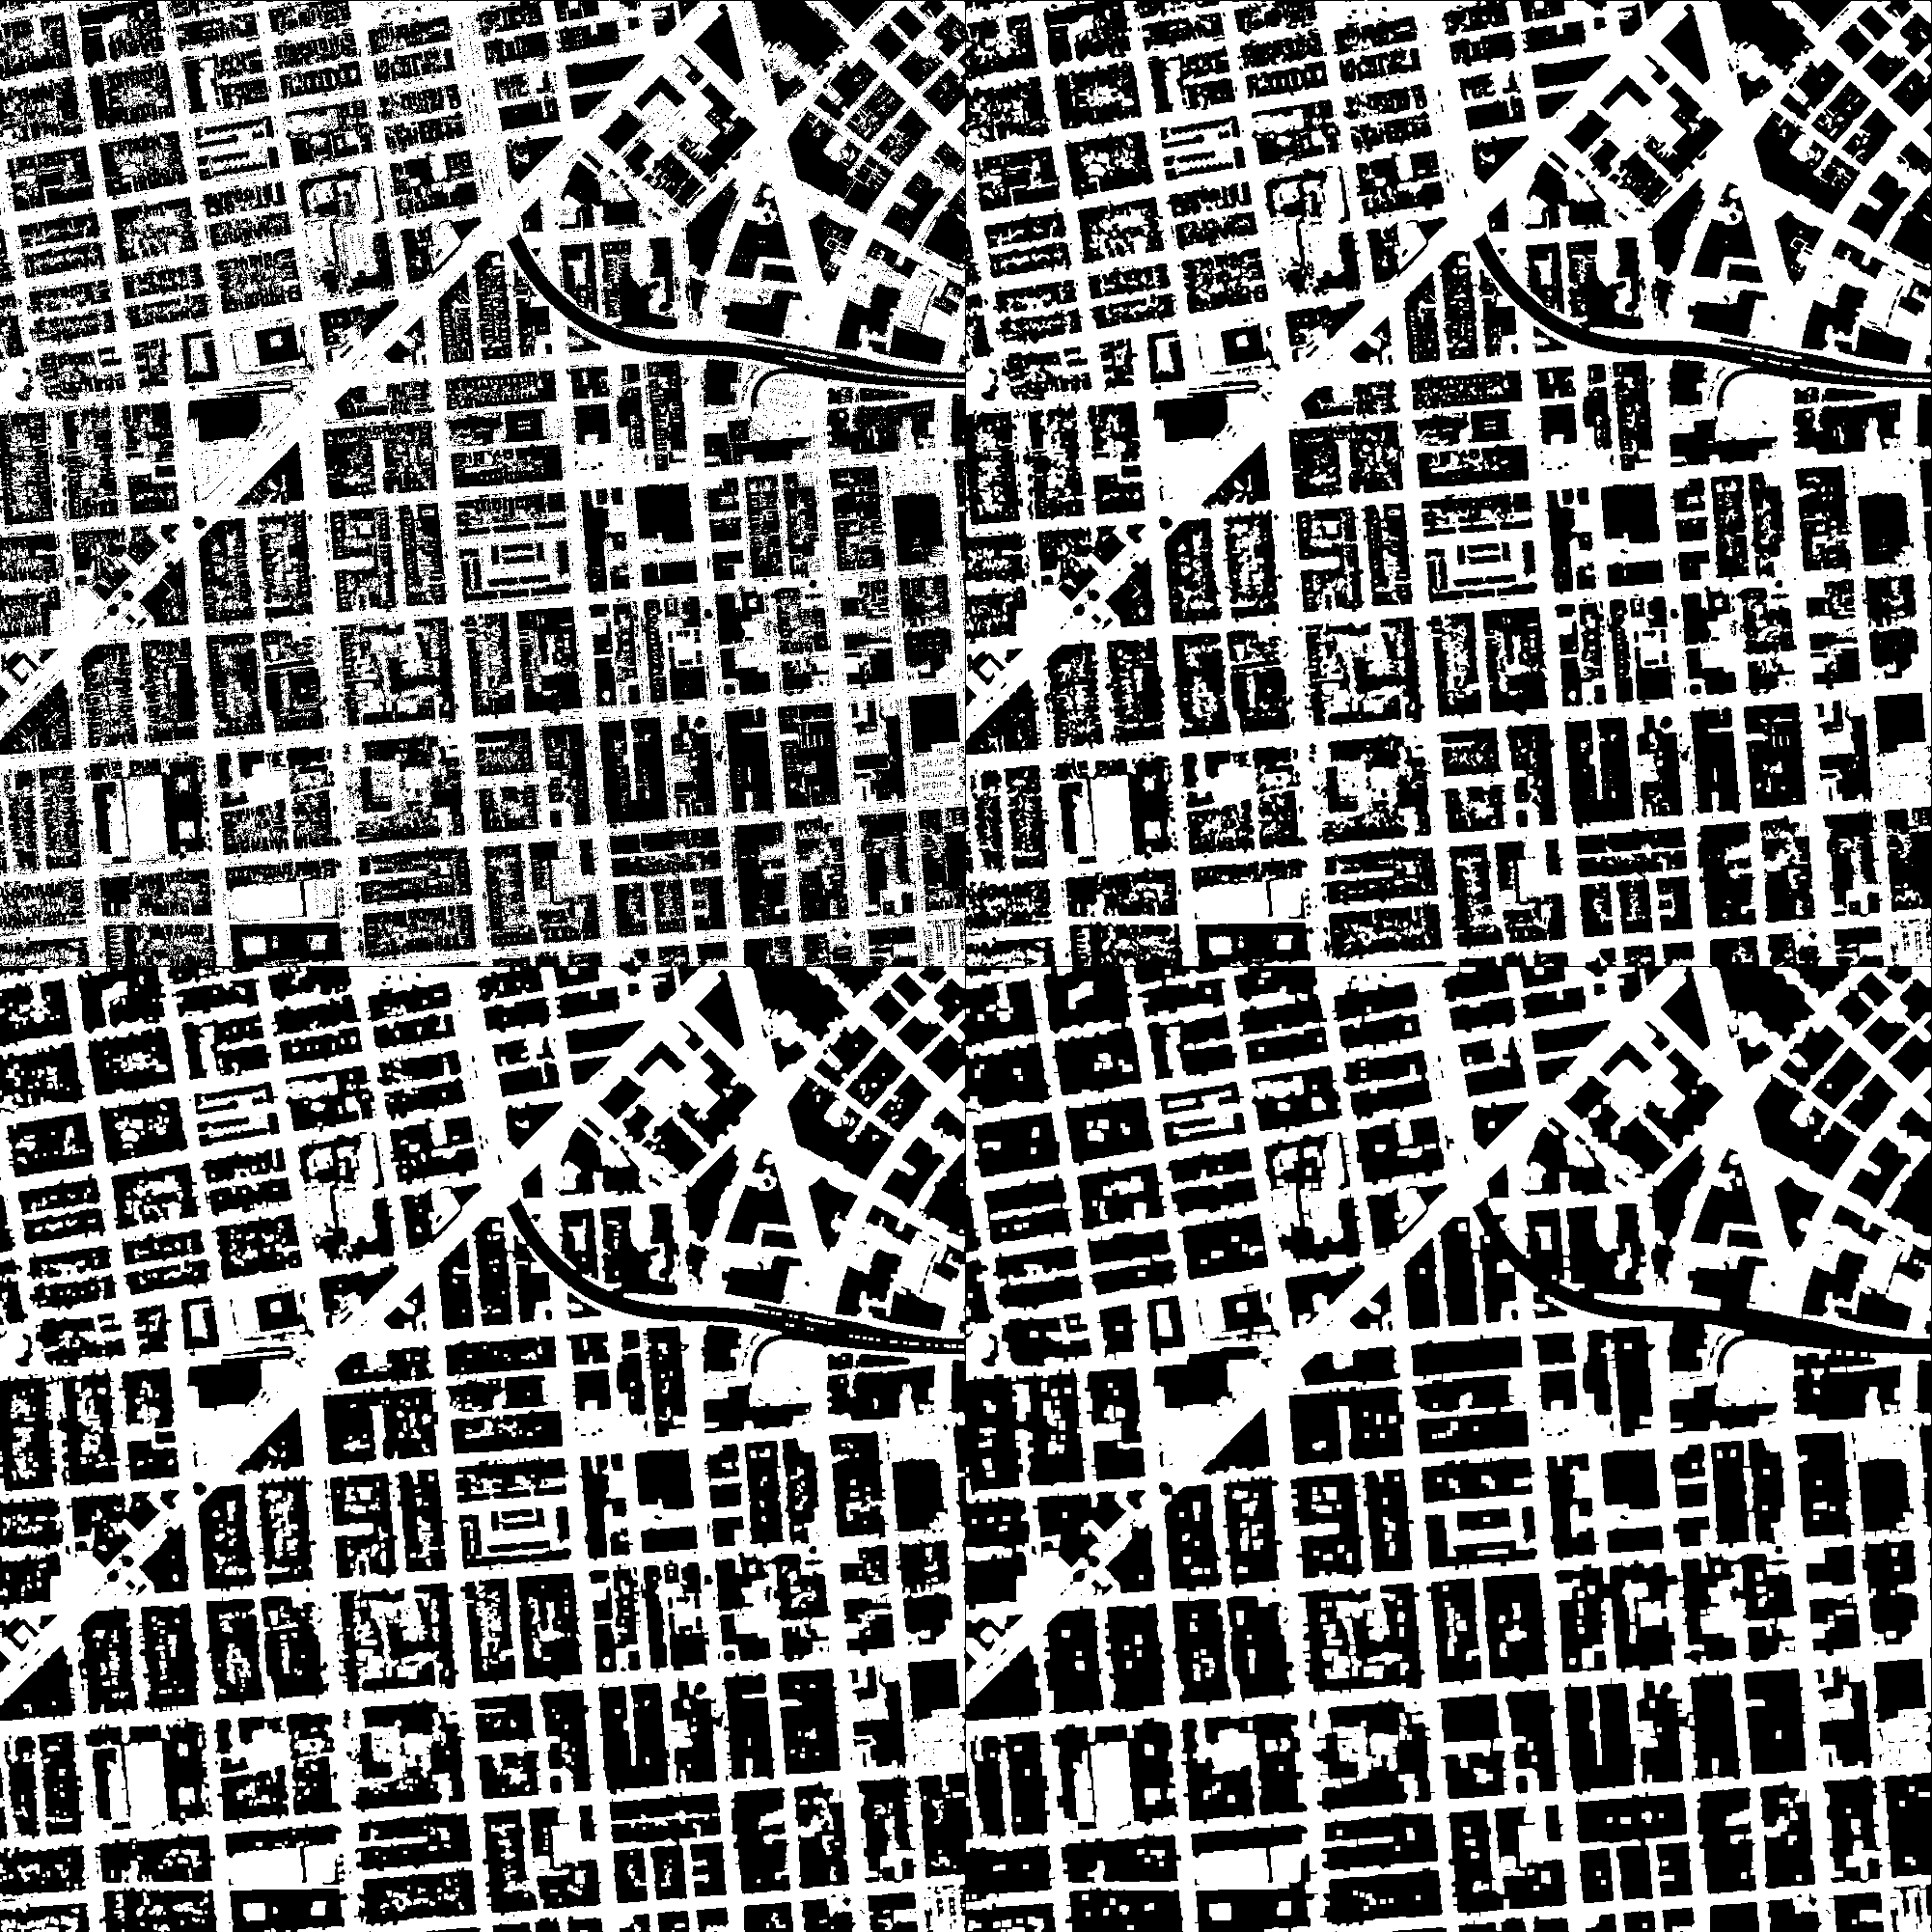

In [19]:
blur_open_1 = cv2.morphologyEx(blur, cv2.MORPH_OPEN, M, (-1,-1),iterations = 1)
blur_open_2 = cv2.morphologyEx(blur, cv2.MORPH_OPEN, M, (-1,-1),iterations = 2)
temp_3 = cv2.vconcat([cv2.hconcat([image,blur]),cv2.hconcat([blur_open_1,blur_open_2])])
cv2_imshow(temp_3)

In [24]:
def get_cc(ground_mask):
  # Perform connected component analysis
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(ground_mask, connectivity=4)

  # Set the minimum area threshold for filtering small patches
  min_area_threshold = 150

  # Create a random color map for coloring the components
  color_map = np.random.randint(low=0, high=255, size=(num_labels, 3), dtype=np.uint8)
  output_image = np.zeros((ground_mask.shape[0], ground_mask.shape[1], 3), dtype=np.uint8)

  # Filter small patches
  for label in range(1, num_labels):
      area = stats[label, cv2.CC_STAT_AREA]
      if area >= min_area_threshold:
          component_color = color_map[label].tolist()
          output_image[labels == label] = component_color
          print(f"Component {label}: Area = {area}")


  largest_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

  road_mask_raw = (labels == largest_label).astype(np.uint8) * 255
  return road_mask_raw

In [25]:
road_mask_raw = get_cc(opened_image)

Component 2: Area = 406907
Component 55: Area = 811
Component 114: Area = 179
Component 120: Area = 180
Component 170: Area = 163
Component 171: Area = 432
Component 195: Area = 378
Component 204: Area = 860
Component 233: Area = 307
Component 261: Area = 408
Component 317: Area = 396
Component 392: Area = 308
Component 423: Area = 157
Component 627: Area = 180
Component 732: Area = 368
Component 747: Area = 168
Component 811: Area = 578
Component 815: Area = 246
Component 835: Area = 252
Component 869: Area = 164
Component 947: Area = 249
Component 1119: Area = 191
Component 1123: Area = 374


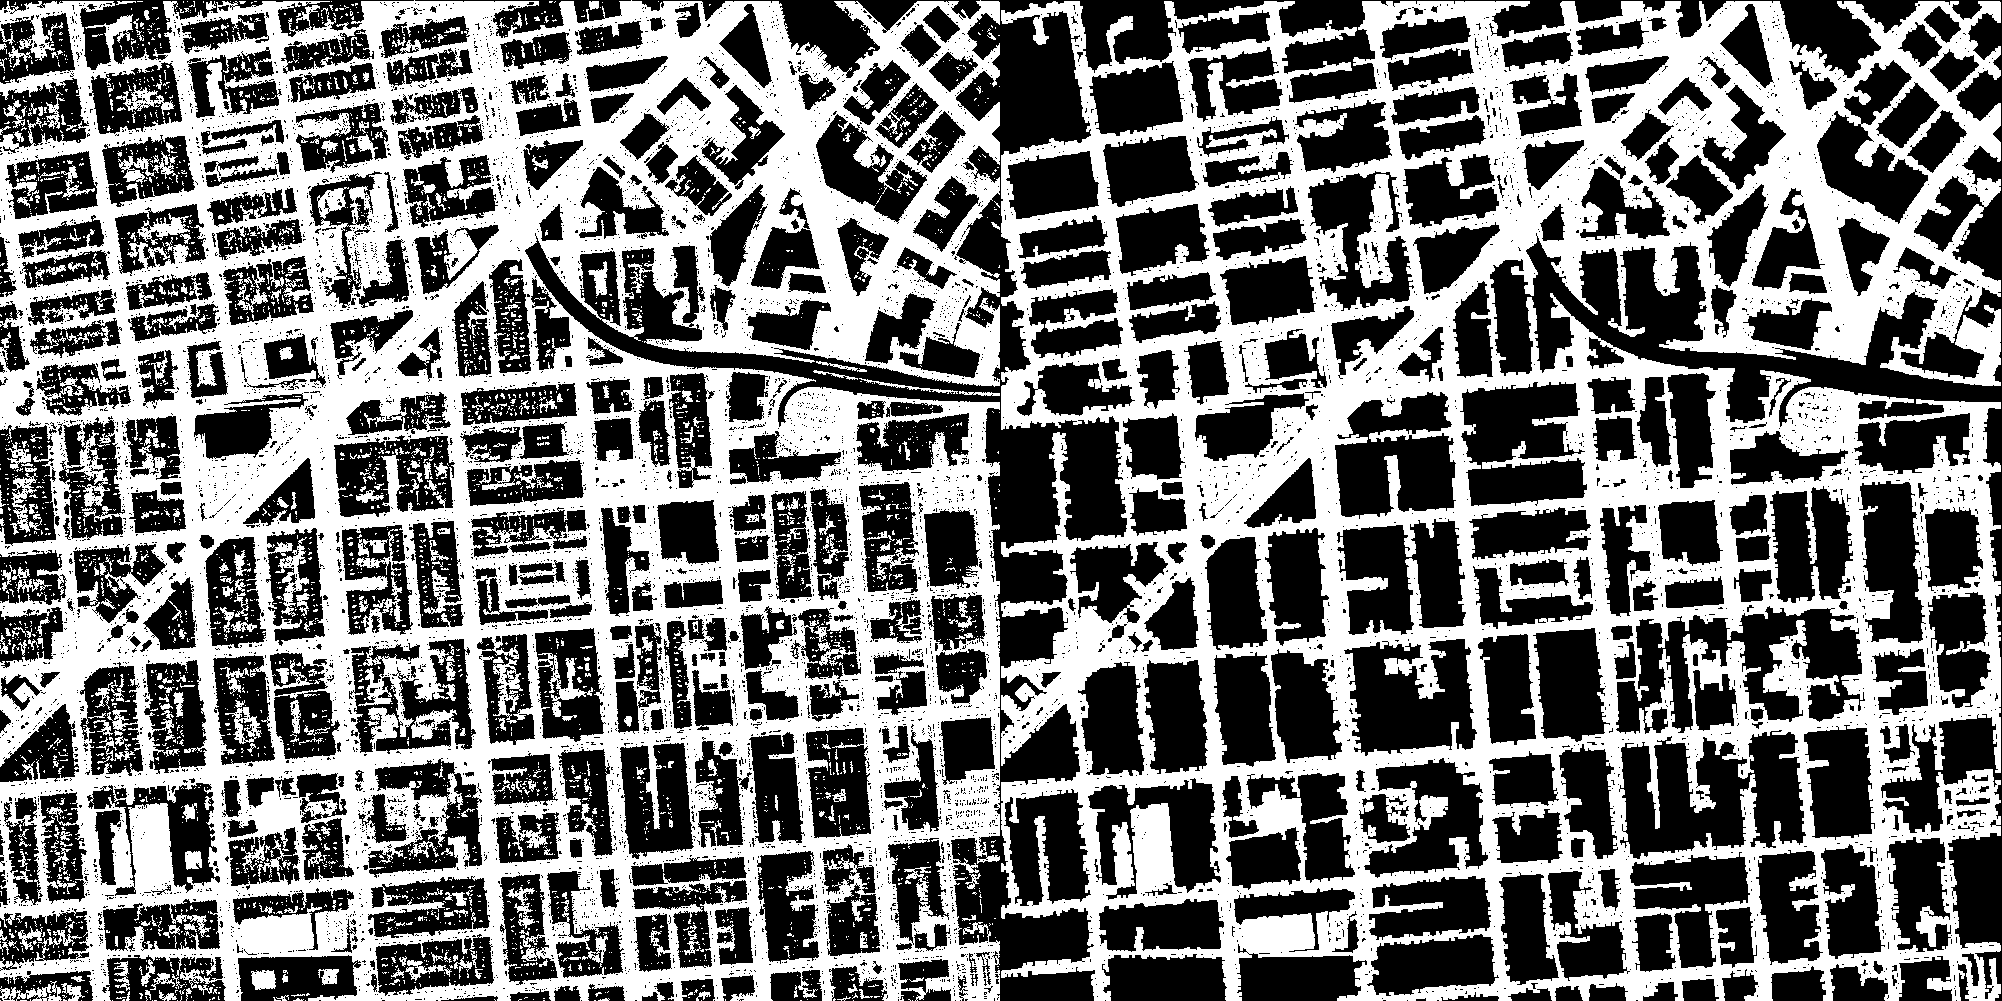

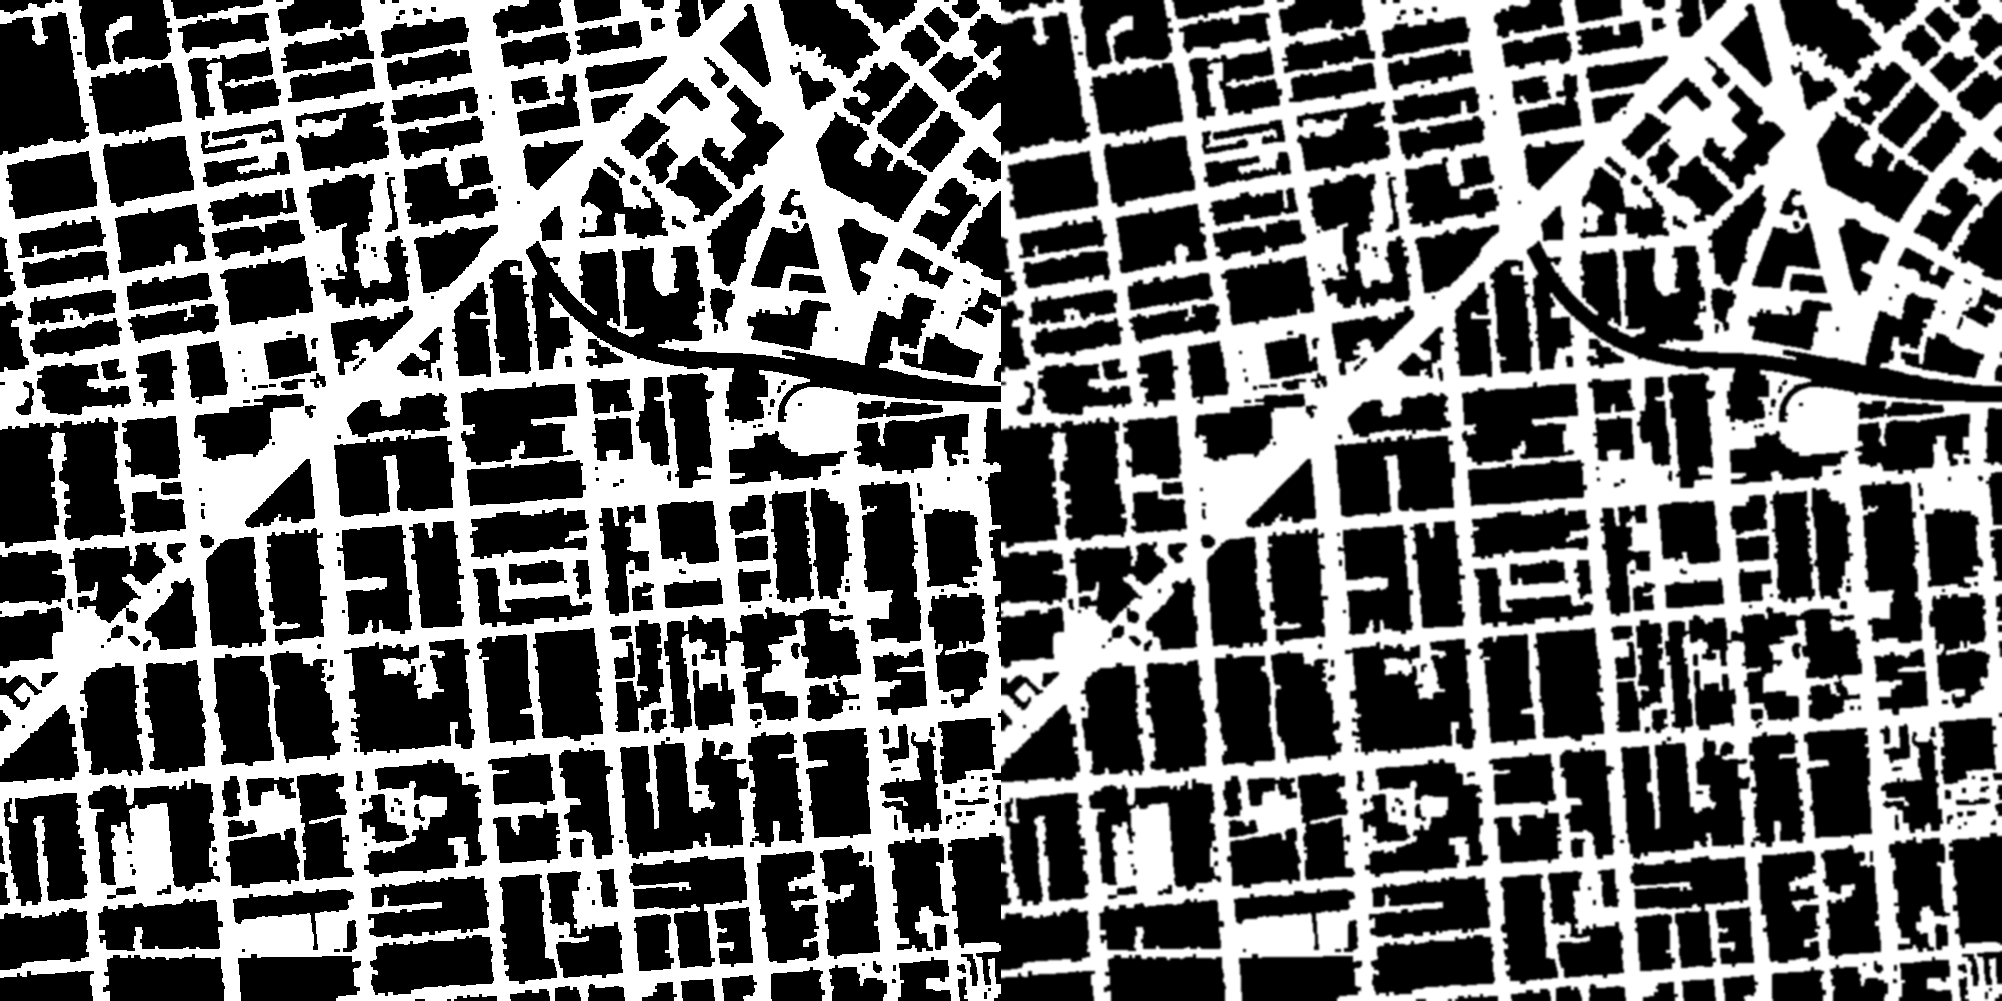

In [26]:
road_mask_morph = cv2.morphologyEx(road_mask_raw, cv2.MORPH_CLOSE,M, (-1,-1),iterations = 1)
road_mask_blur = cv2.GaussianBlur(road_mask_morph, (5, 5), 0)

# road_mask_bi = cv2.bilateralFilter(road_mask_morph, d=100, sigmaColor=0, sigmaSpace=100)

cv2_imshow(cv2.hconcat([image,road_mask_raw]))
cv2_imshow(cv2.hconcat([road_mask_morph,road_mask_blur]))

In the end, I decided to go with Morphological opening + Connected components because it seemed to work best.

After this, my plan was initially to use canny edge detection and then use hough lines but it was not working because the edges were far from straigt. Using approximation methods such
as [Douglas-peucker approximation](https://stackoverflow.com/questions/59383119/how-to-approximate-jagged-edges-as-lines-using-python-opencv) and its modified version didnt work. The edges were too jagged. So I decided to detect lines on the road mask itself.

In [27]:
road_mask = road_mask_raw

In [28]:
def show_lines(lines,road_mask):
  overlay_image = np.zeros((road_mask.shape[0], road_mask.shape[1], 3), dtype=np.uint8)
  road_mask_color = cv2.cvtColor(road_mask, cv2.COLOR_GRAY2BGR)
  overlay_image = cv2.addWeighted(overlay_image, 1, road_mask_color, 1, 0)

  for line in lines:
      x1, y1, x2, y2 = line[0]

      cv2.line(overlay_image, (x1, y1), (x2, y2), (0, 255, 0), thickness=1)
      cv2.circle(overlay_image, (x1, y1), radius=1, color=(0, 0, 255), thickness=-1)
      cv2.circle(overlay_image, (x2, y2), radius=1, color=(0, 0, 255), thickness=-1)
  cv2_imshow(overlay_image)

523


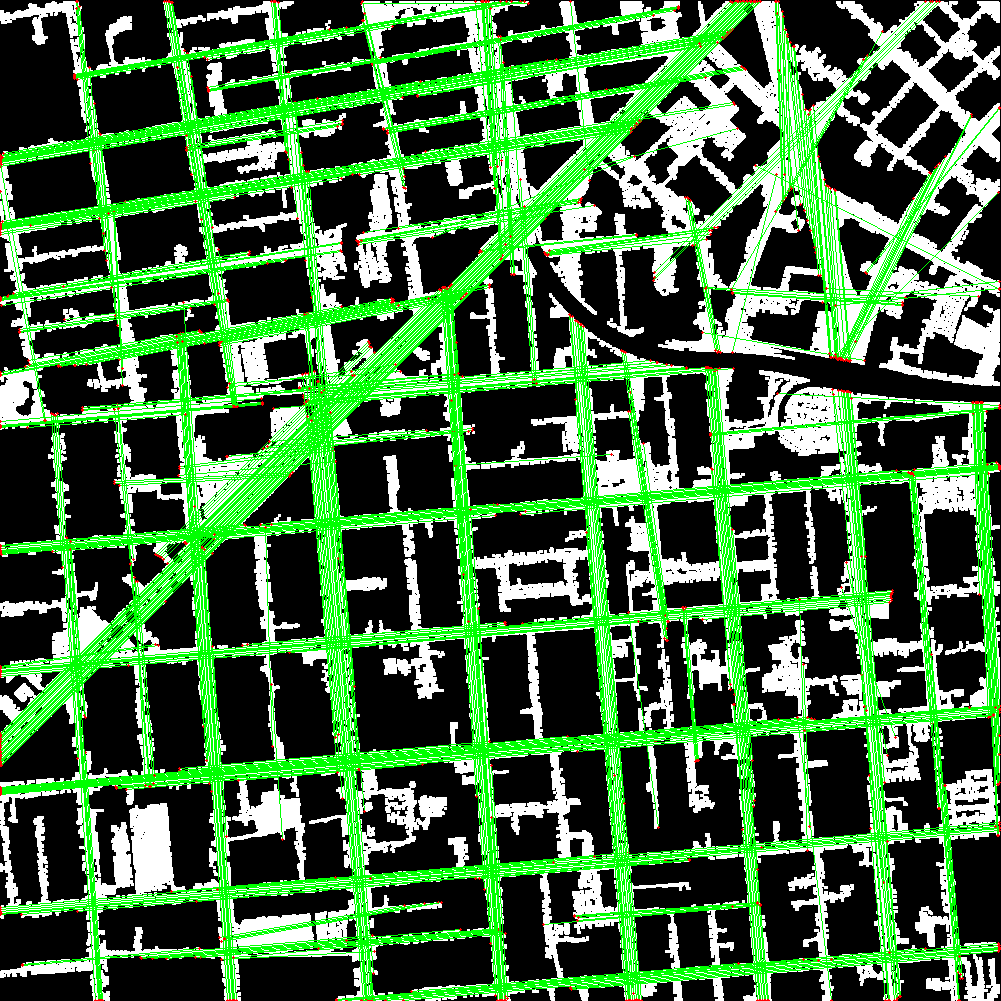

In [29]:
lines = cv2.HoughLinesP(road_mask, rho=1, theta=np.pi/180, threshold=180, minLineLength=150, maxLineGap=12)
print(len(lines))
show_lines(lines,road_mask)

The lines actually look good here, but a lot of them do not start or end where they should start or end. Which is problematic as it dosnt cover the whole road, or cover it diagonally which is not ideal. Below is cropped top right section of the image above.

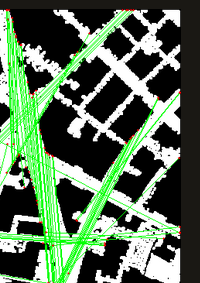

HoughLinesP detects line segments. The line can originate and end only on a road pixel which is next to a black (non road) pixel OR a road pixel on image edge.

This means a line can originate from your house to a house right in front of you. We want a line to travel the length of raod and that is just opposite.

To counter the above mentioned problems, proper parameter tuning is needed.

Curved roads are still a problem

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def segment_roads(lines,eps= 50,min_samples = 2):
# Cluster the lines based on x1, y1, x2, y2 using DBSCAN
  X = np.array([[line[0][0], line[0][1], line[0][2], line[0][3]] for line in lines])
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  labels = dbscan.fit_predict(X)
  unique_labels = np.unique(labels)
  unique_labels = unique_labels[unique_labels != -1]

  print(len(unique_labels))
  return labels, unique_labels, X

Clustering the lines based on their points using DBSCAN

In [31]:
labels, unique_labels, X = segment_roads(lines,50,2)

103


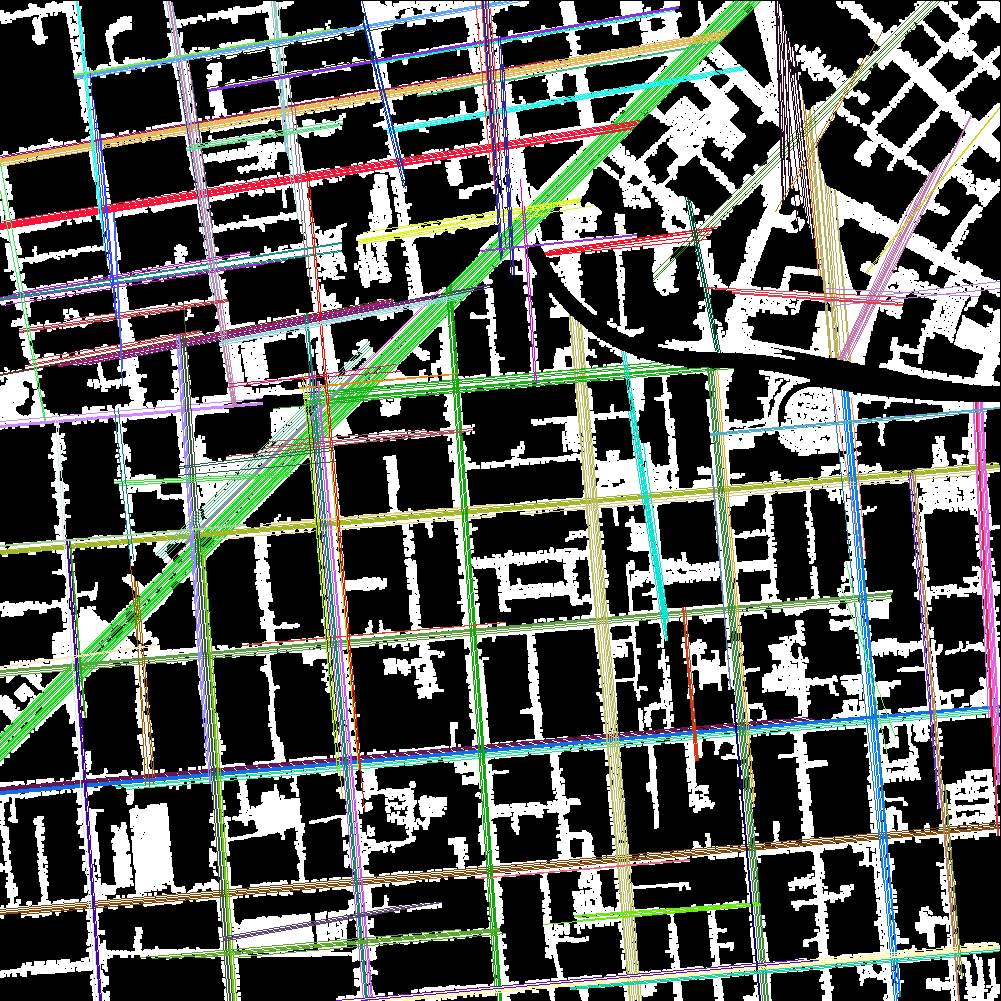

In [37]:
num_colors = len(unique_labels)
colors = np.random.randint(0, 256, (num_colors, 3), dtype=np.uint8)

overlay_image = np.zeros((road_mask.shape[0], road_mask.shape[1], 3), dtype=np.uint8)
road_mask_color = cv2.cvtColor(road_mask, cv2.COLOR_GRAY2BGR)
overlay_image = cv2.addWeighted(overlay_image, 1, road_mask_color, 1, 0)

clusters = []
for i, label in enumerate(unique_labels):
    cluster_lines = X[labels == label]
    clusters.append(cluster_lines)
    color = list(colors[i])
    for line in cluster_lines:
        x1, y1, x2, y2 = line
        cv2.line(overlay_image, (x1, y1), (x2, y2), (int(color[0]),int(color[1]),int(color[2])), thickness=1)
        # cv2.circle(overlay_image, (x1, y1), radius=1, color=(0, 0, 255), thickness=-1)
        # cv2.circle(overlay_image, (x2, y2), radius=1, color=(0, 0, 255), thickness=-1)

cv2_imshow(overlay_image)


The clustering is not perfect. For e.g.
These three clusters should be one but they are not, because the lines do not originate at same point (they are diagonal wrt road)
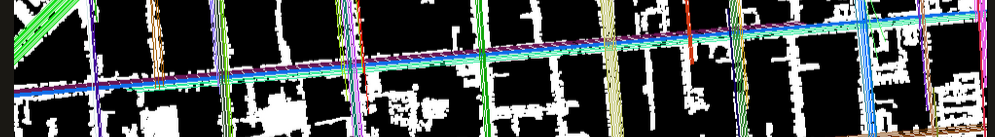
This will be hard to remove.

But we can still try sorting out the bad apples,
Here, I remove 
1. clusters with too less lines in the cluster (Diagonal lines tend to split in multiple clusters)
2. Clusters with too small width (too large width can be added)
3. Clusters which have more width than length (A road should have more length than width, right?)

Road width is calculated by getting the distance between the lines which are farthest from each other.
Road length is the length of the biggest line

In [38]:
import numpy as np
import cv2

road_widths = []
road_lengths = []
valid_clusters = []

for cluster in clusters:

    cluster_lines = np.array(cluster)
    line_lengths = np.sqrt(np.sum(np.diff(cluster_lines.reshape(-1, 2, 2), axis=1) ** 2, axis=2))

    # Calculate the road width as the maximum distance between lines in the cluster
    line_distances = np.sqrt(np.sum(np.diff(cluster_lines.reshape(-1, 2, 2), axis=0) ** 2, axis=1))
    road_width = np.max(line_distances)

    # Calculate the road length as the maximum length of lines in the cluster
    road_length = np.max(line_lengths)

    if len(cluster) < 4 or road_width < 5 or road_width > 0.2 * road_length:
        continue

    road_widths.append(road_width)
    road_lengths.append(road_length)
    valid_clusters.append(cluster)

# for i in range(len(valid_clusters)):
#     print("Cluster:", i)
#     print("Road Width: {:.2f}".format(road_widths[i]))
#     print("Road Length: {:.2f}".format(road_lengths[i]))


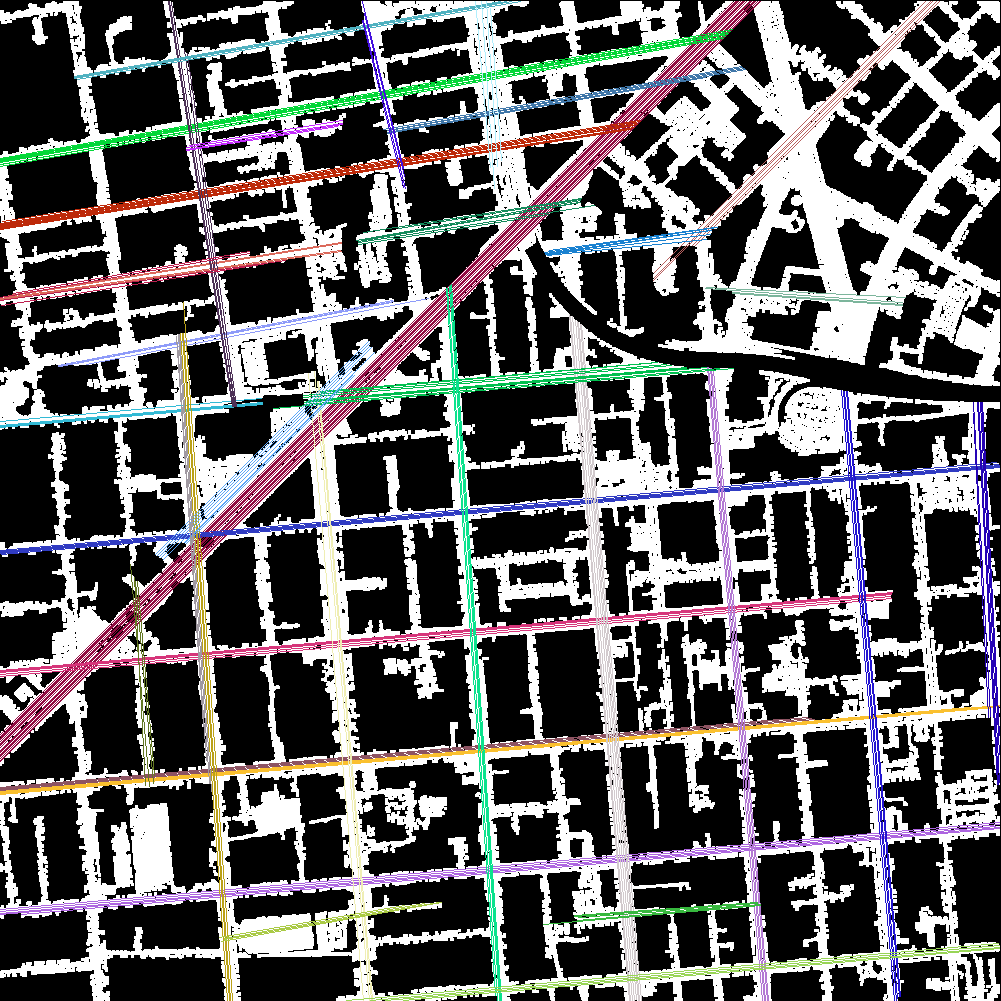

In [41]:
num_colors = len(valid_clusters)
colors = np.random.randint(0, 256, (num_colors, 3), dtype=np.uint8)

overlay_image = np.zeros((road_mask.shape[0], road_mask.shape[1], 3), dtype=np.uint8)
road_mask_color = cv2.cvtColor(road_mask, cv2.COLOR_GRAY2BGR)
overlay_image = cv2.addWeighted(overlay_image, 1, road_mask_color, 1, 0)

clusters = []
for i, cluster in enumerate(valid_clusters):
    for line in cluster:
        x1, y1, x2, y2 = line
        cv2.line(overlay_image, (x1, y1), (x2, y2), (int(colors[i][0]),int(colors[i][1]),int(colors[i][2])), thickness=1)
        # cv2.circle(overlay_image, (x1, y1), radius=1, color=(0, 0, 255), thickness=-1)
        # cv2.circle(overlay_image, (x2, y2), radius=1, color=(0, 0, 255), thickness=-1)

cv2_imshow(overlay_image)


With more time, this could be better but this is what we for now.

Room for improvement
1. Curved roads
2. Better clustering / filtering
3. Better pre-processing

In [42]:
print(height,width)

1000 1000


Converting the measurements from pixel units to metres. The point cloud was 1500 x 1500 m^2, The image is 1000 x 1000 pixels so we need to scale it up by 1.5

In [46]:
l = 1500
s = l/height
s

1.5

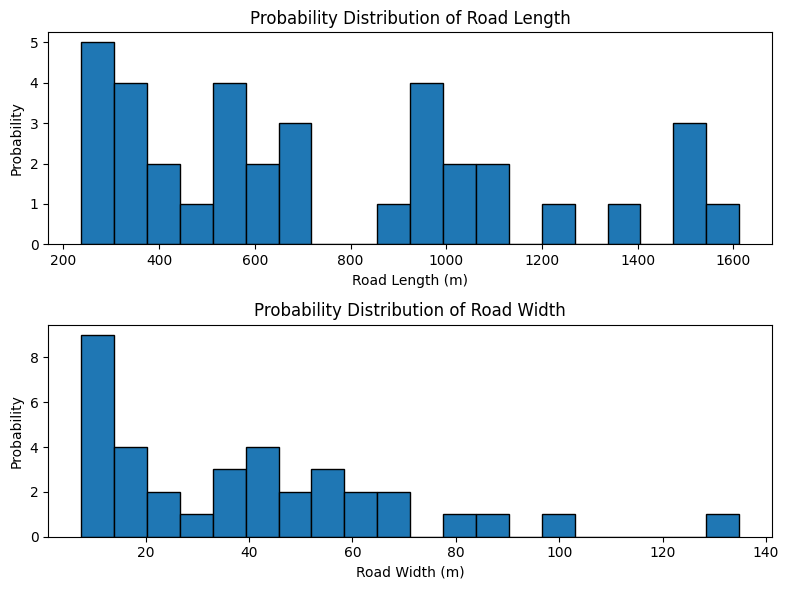

In [47]:
scaled_lengths = np.array(road_lengths) * s
scaled_widths = np.array(road_widths) * s

# Create separate probability graphs for road length and width
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.hist(scaled_lengths, bins=20, edgecolor='black')
plt.xlabel("Road Length (m)")
plt.ylabel("Probability")
plt.title("Probability Distribution of Road Length")

plt.subplot(2, 1, 2)
plt.hist(scaled_widths, bins=20, edgecolor='black')
plt.xlabel("Road Width (m)")
plt.ylabel("Probability")
plt.title("Probability Distribution of Road Width")

plt.tight_layout()
plt.show()


The road lengths have more "small roads" than there should be. Meanwhile, the road width has some roads with to high width. This can be easily solved but the accuracy of width would still be an issue

Below is some incomplete code. I am trying to make and intersect the mask of area covered by lines and the road mask to display it better
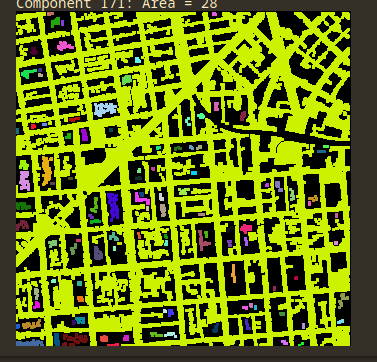
Like this, properly fill roads with colours but different colours for different roads. It is not working for now and I am figuring it out

In [80]:
boxes = []
for cluster in valid_clusters:
    cluster_lines = np.array(cluster)
    # print(cluster)
    farthest_indices = np.argsort(np.linalg.norm(cluster_lines[:, :2] - cluster_lines[:, 2:], axis=1))[-2:]
    farthest_lines = cluster_lines[farthest_indices]
    # print(farthest_lines)
    box = cv2.minAreaRect(np.vstack((farthest_lines[:, :2], farthest_lines[:, 2:])))
    boxes.append(box)

[[  0 736 735   1]
 [  0 756 755   1]
 [  0 739 738   1]
 [  0 752 751   1]
 [  0 747 746   1]
 [  0 743 742   1]
 [  0 750 749   1]
 [  0 760 759   1]
 [  0 755 754   1]
 [  0 758 757   1]
 [  0 751 750   1]
 [  0 734 732   2]
 [  1 736 736   1]
 [  0 761 760   1]
 [  0 741 740   1]
 [  0 744 743   1]
 [  0 738 737   1]
 [  0 754 753   1]
 [  0 745 744   1]]
[[  0 760 759   1]
 [  0 761 760   1]]
[[  0 793 999 706]
 [  0 792 999 705]
 [  0 794 995 707]
 [  0 791 969 707]]
[[  0 793 999 706]
 [  0 792 999 705]]
[[  0 550 996 462]
 [  1 554 999 467]
 [  0 551 998 464]
 [  0 553 999 466]
 [  0 552 999 465]]
[[  0 553 999 466]
 [  0 552 999 465]]
[[  0 914 999 827]
 [  0 911 999 824]
 [  0 913 995 826]
 [ 21 914 999 828]
 [  0 909 999 822]]
[[  0 911 999 824]
 [  0 909 999 822]]
[[  0 790 814 719]
 [  0 789 811 718]
 [  0 788 807 717]
 [  0 787 778 719]]
[[  0 789 811 718]
 [  0 790 814 719]]
[[185 543 439 289]
 [167 563 443 287]]
[[185 543 439 289]
 [167 563 443 287]]
[[  0 676 891 598]


In [78]:
boxes = []
for cluster in valid_clusters:
    cluster_lines = np.array(cluster)
    farthest_indices = np.argsort(np.linalg.norm(cluster_lines[:, :2] - cluster_lines[:, 2:], axis=1))[-2:]
    farthest_lines = cluster_lines[farthest_indices]
    box = cv2.minAreaRect(np.vstack((farthest_lines[:, :2], farthest_lines[:, 2:])))
    width_increase = box[1][0] * 0.05  # 5% increase on each side
    center = box[0]
    new_width = box[1][0] + (2 * width_increase)  # Increase width on both sides
    new_height = box[1][1]
    angle = box[2]
    box = (center, (new_width, new_height), angle)
    boxes.append(box)


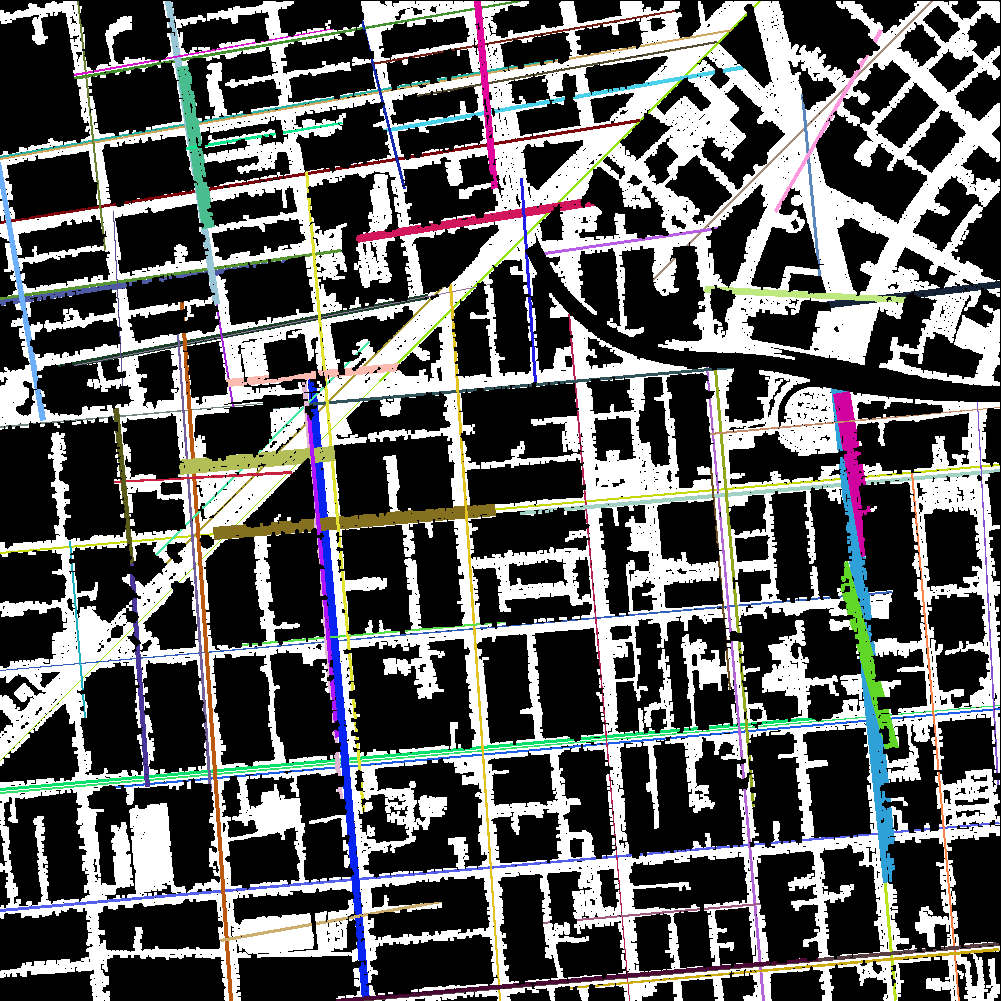

In [82]:
colored_mask = cv2.cvtColor(road_mask, cv2.COLOR_GRAY2BGR)
colors = np.random.randint(0, 256, (len(boxes), 3), dtype=np.uint8)

for i, box in enumerate(boxes):
    box_points = cv2.boxPoints(box).astype(np.int32)

    box_mask = np.zeros_like(road_mask, dtype=np.uint8)
    cv2.drawContours(box_mask, [box_points], 0, 255, -1)

    intersection = cv2.bitwise_and(road_mask, box_mask)

    color = tuple(colors[i].tolist())
    colored_mask[np.where(intersection != 0)] = color


cv2_imshow(colored_mask)